# UCI mHealth Classification - CNN-LSTM
- https://archive.ics.uci.edu/dataset/319/mhealth+dataset

#### 데이터 구조
- 10명의 참가자별로 mHealth_subject<SUBJECT_ID>.log 파일 존재
- 가속도, 자이로, 자기장, 심전도 -> 총 23개의 feature

#### 라벨
0. Other
1. Standing still
2. Sitting and relaxing
3. Lying down
4. Walking
5. Climbing stairs
6. Waist bends forward
7. Frontal elevation of arms
8. Knees bending (crouching)
9. Cycling
10. Jogging
11. Running
12. Jump front & back


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
base_dir = "/content/drive/MyDrive/AI_data/MHEALTHDATASET"
dfs = []
col_names = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg1', 'ecg2',
    'acc_left_ankle_x', 'acc_left_ankle_y', 'acc_left_ankle_z',
    'gyro_left_ankle_x', 'gyro_left_ankle_y', 'gyro_left_ankle_z',
    'magnet_left_ankle_x', 'magnet_left_ankl6e_y', 'magnet_left_ankle_z',
    'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z',
    'gyro_right_arm_x', 'gyro_right_arm_y', 'gyro_right_arm_z',
    'magnet_right_arm_x', 'magnet_right_arm_y', 'magnet_right_arm_z',
    'label', 'subject'
]

for i in range(1, 11):
    path = os.path.join(base_dir, f"mHealth_subject{i}.log")
    df_i = pd.read_csv(path, sep='\t', header=None)
    df_i['subject'] = i
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(how='any', axis=0)
df.columns = col_names
df

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z,label,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-4.5781,0.187760,-0.449020,-1.01030,0.034483,-2.35000,-1.610200,-0.030899,0,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.449020,-1.01030,0.034483,-2.16320,-0.882540,0.326570,0,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.449020,-1.01030,0.034483,-1.61750,-0.165620,-0.030693,0,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.456860,-1.00820,0.025862,-1.07710,0.006945,-0.382620,0,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.456860,-1.00820,0.025862,-0.53684,0.175900,-1.095500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-9.2476,-0.248070,-2.62230,0.230250,0.234430,1.7849,-9.8287,0.29725,-0.341370,-0.90056,...,-8.9071,0.294230,0.041176,-0.99384,-0.480600,2.40890,7.496100,7.915500,0,10
1215741,-9.4632,-0.073513,-2.11190,0.276300,0.284670,1.8687,-9.8766,0.46236,-0.341370,-0.90056,...,-8.7455,0.448140,0.041176,-0.99384,-0.480600,1.69450,7.866000,7.897500,0,10
1215742,-9.4011,-0.144580,-3.02350,0.288850,0.301410,1.6928,-9.9290,0.16631,-0.341370,-0.90056,...,-9.1155,0.450480,0.041176,-0.99384,-0.480600,1.15770,8.052800,7.884900,0,10
1215743,-9.3732,-0.026252,-2.70760,0.351650,0.347460,1.5279,-9.6306,0.30458,-0.341370,-0.90056,...,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0.27441,9.487900,5.325800,0,10


In [4]:
df.label.value_counts()

,count
label,
0,872550
1,30720
2,30720
3,30720
4,30720
9,30720
5,30720
11,30720
10,30720


In [5]:
# downsampling
from sklearn.utils import resample

df_majority = df[df.label==0]
df_minorities = df[df.label!=0]

df_majority_downsampled = resample(df_majority, n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.label.value_counts()

,count
label,
1,30720
3,30720
2,30720
4,30720
9,30720
11,30720
5,30720
10,30720
0,30000


In [6]:
# df.to_csv('/content/drive/MyDrive/AI_data/MHEALTHDATASET/mhealth_resampled_data.csv',index = False)

In [7]:
df.isnull().sum()

,0
acc_chest_x,0
acc_chest_y,0
acc_chest_z,0
ecg1,0
ecg2,0
acc_left_ankle_x,0
acc_left_ankle_y,0
acc_left_ankle_z,0
gyro_left_ankle_x,0
gyro_left_ankle_y,0


In [8]:
# 피험자 1-6: 훈련, 피험자 7-8: 검증, 피험자 8-9: 테스트
train = df[~df['subject'].isin([7, 8, 9, 10])]
val = df[df['subject'].isin([7, 8])]
test = df[df['subject'].isin([9, 10])]

train.shape, val.shape, test.shape

((226128, 25), (73326, 25), (73741, 25))

In [9]:
X_train = train.drop(['label','subject'], axis=1)
y_train = train['label']

X_val = val.drop(['label','subject'], axis=1)
y_val = val['label']

X_test = test.drop(['label','subject'], axis=1)
y_test = test['label']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((226128, 23), (226128,), (73326, 23), (73326,), (73741, 23), (73741,))

In [10]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(sc.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(sc.fit_transform(X_test), columns=X_train.columns)

X_train

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,magnet_left_ankle_z,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z
0,-0.087384,-0.180627,-0.786215,0.007915,-0.011472,-0.577582,0.733111,0.855263,0.283638,-0.578020,...,-0.402525,-0.878509,-0.115785,0.092842,-1.287582,0.881529,-0.227001,0.355856,-0.757309,0.065910
1,-0.328788,-0.300078,0.605666,-0.081073,-0.087624,-0.048897,-0.100417,0.083515,-0.577486,-0.415903,...,0.011245,0.142070,-0.403044,0.292032,-1.181228,-0.788334,-0.017597,-0.007098,-0.073927,-0.046895
2,0.241808,0.040644,-0.641235,0.070732,-0.107931,0.010368,0.093603,-0.501927,-0.867129,0.049140,...,0.540380,0.419364,-0.149160,-0.108985,-0.159630,-0.799296,-1.414959,-0.118250,-0.093139,-0.227639
3,-0.354832,-0.009466,0.177121,-0.447507,-1.224823,-0.497284,-0.085610,0.353416,-1.442512,-0.458564,...,-0.030661,0.347123,-0.554803,-0.268771,0.292298,-1.000270,-1.567971,0.008544,-0.094608,-0.020982
4,0.244441,0.152781,-0.843392,-0.332342,-0.184085,-1.151754,-0.146134,-0.361905,1.782740,0.484325,...,2.124397,-0.463871,-0.334905,-0.028403,-0.584985,-0.481392,0.522008,0.201140,0.141492,-0.024674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226123,-0.998367,0.135213,-0.547845,-0.248588,-0.544528,-0.299251,-0.707677,0.882140,-0.432654,-0.603626,...,0.449349,-0.424959,-0.777297,0.256151,-0.190019,-1.164606,-0.086059,-0.832750,-0.733695,-0.744858
226124,-1.148293,0.104779,-0.661009,-0.180527,-0.544528,0.232369,-0.590383,0.757580,-0.432654,-0.603626,...,0.287044,-0.667105,-1.022036,0.412414,-0.190019,-1.164606,-0.086059,-0.891081,-1.279427,-0.798790
226125,-1.076286,0.134339,-1.033485,-0.107247,-0.534377,1.156834,-0.723743,0.356439,-0.432654,-0.603626,...,0.031366,-0.789524,-1.428916,0.539305,-0.190019,-1.164606,-0.086059,-0.798699,-2.073697,-0.786247
226126,-0.955557,0.620911,-1.302284,0.002681,-0.427768,0.927660,-0.718710,-0.643712,-0.354383,-0.629232,...,0.009413,-0.565365,-1.578079,0.372380,-0.190019,-1.164606,-0.086059,-0.468607,-2.871990,-0.626123


### create_dataset
- X에 dataframe을 입력 -> 여러 개의 columns
- x.shape이 (time_steps, n_features)이기 때문에 Xs.shape은 (n_samples, time_steps, n_features). 따라서 reshape이 필요 없음
- ys: 윈도우 내 최빈값을 라벨로 설정, 1D 리스트
- sklearn, keras에서 y를 (n_samples, 1) 형태로 사용하기 때문에 reshape

In [11]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [12]:
TIME_STEPS = 200
STEPS = 40

X_train ,y_train = create_dataset(X_train, y_train, TIME_STEPS, STEPS)
X_val, y_val = create_dataset(X_val, y_val, TIME_STEPS, STEPS)
X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS, STEPS)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")

Training sequences: (5649, 200, 23)
Validation sequences: (1829, 200, 23)
Test sequences: (1839, 200, 23)


In [26]:
input_shape = (200, 23)
num_classes = 13

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling1D(2))
model.add(LSTM(64))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 200, 32)        │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 200, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 200, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,853 (202.55 KB)

 Trainable params: 51,661 (201.80 KB)

 Non-trainable params: 192 (768.00 B)

None


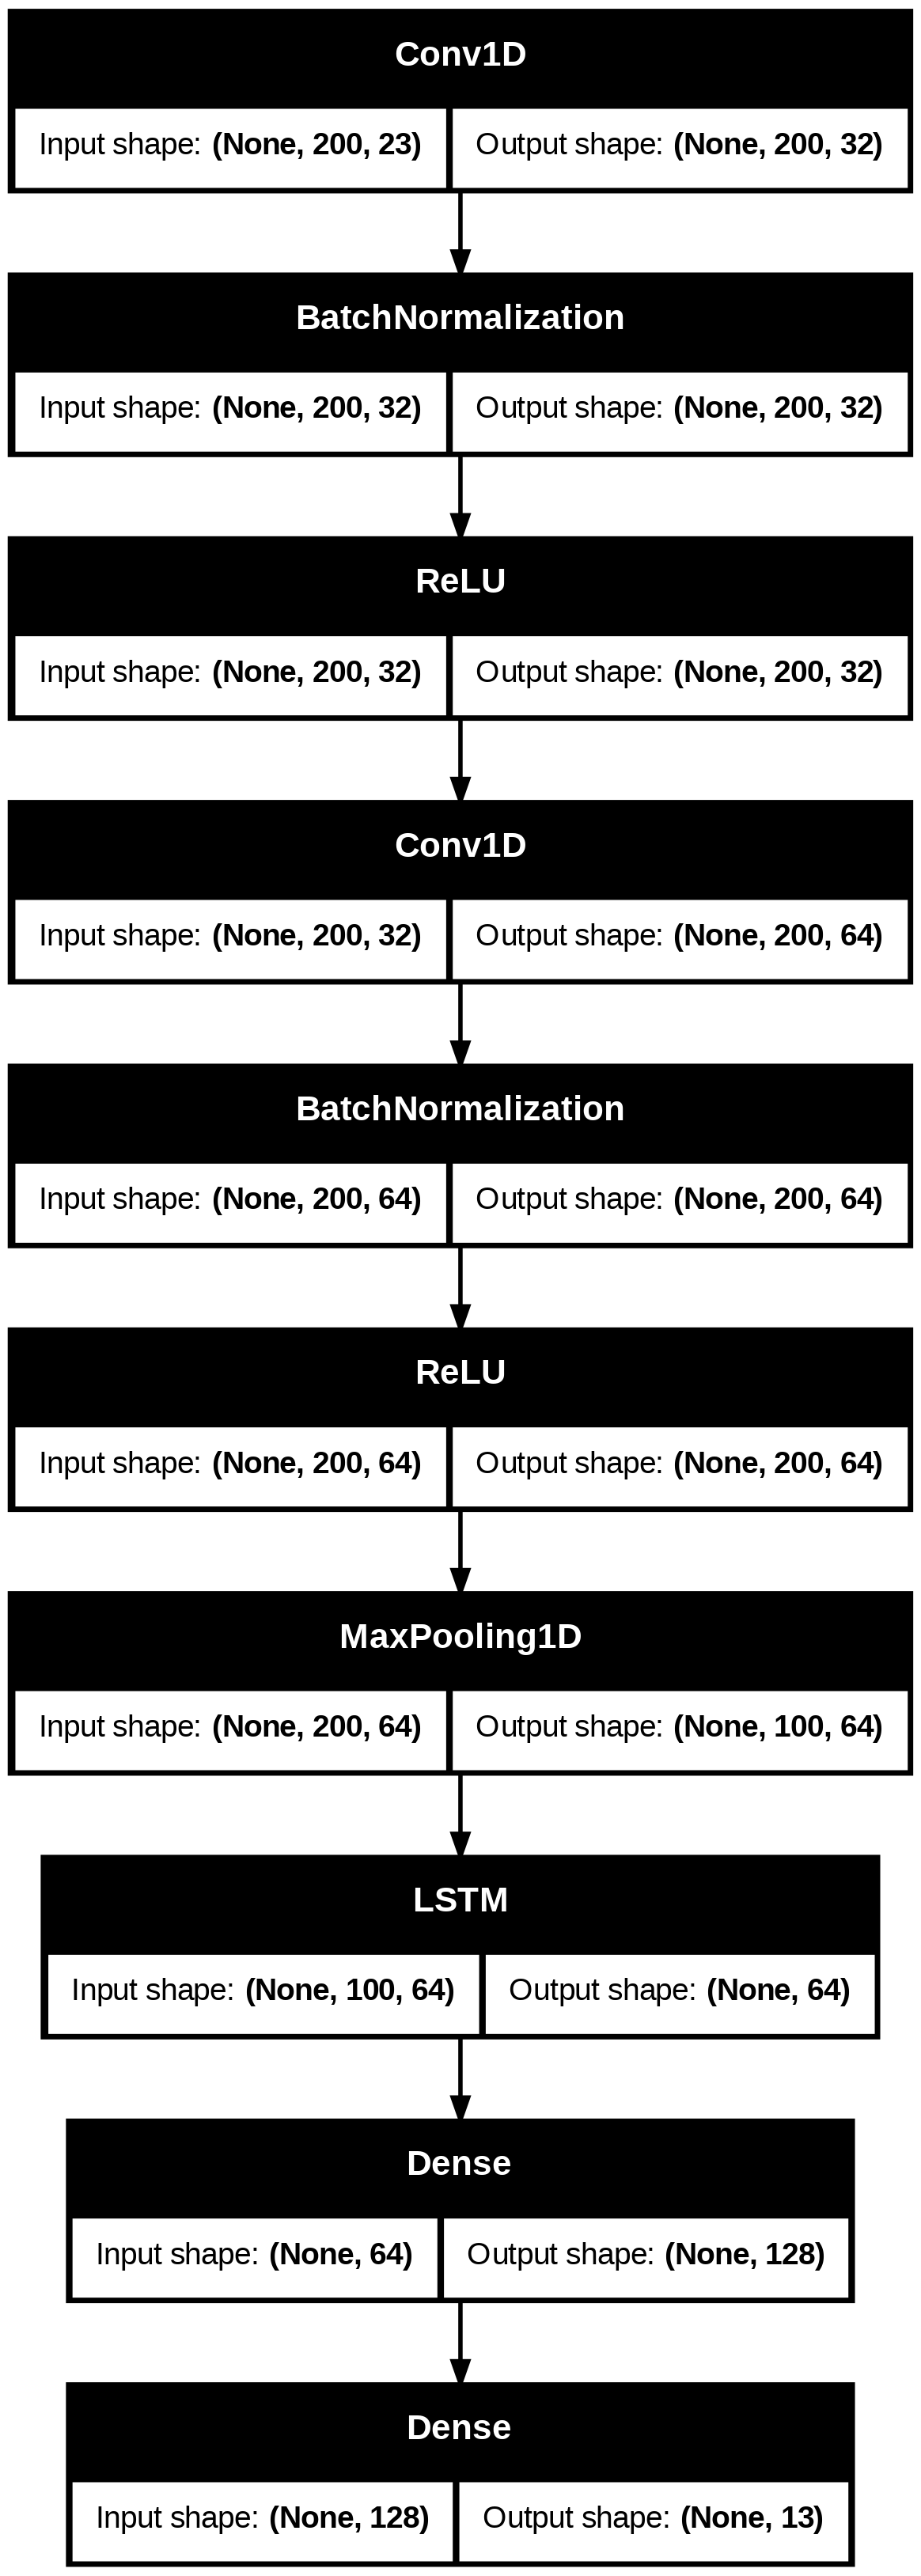

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
callbacks = [
            ModelCheckpoint(
                "mhealth_CNN_LSTM_best.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [29]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4351 - sparse_categorical_accuracy: 0.5701
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.76217, saving model to mhealth_CNN_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.4316 - sparse_categorical_accuracy: 0.5712 - val_loss: 0.8332 - val_sparse_categorical_accuracy: 0.7622
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2255 - sparse_categorical_accuracy: 0.9289
Epoch 2: val_sparse_categorical_accuracy improved from 0.76217 to 0.79934, saving model to mhealth_CNN_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2253 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.7389 - val_sparse_categorical_accuracy: 0.7993
Epoch 3/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9656
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.79934
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.9359 - val_sparse_categorical_accuracy: 0.7326
Epoch 4/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9764
Epoch 4: val_sparse_categorical_accuracy improved from 0.79934 to 0.82559, saving model to mhealth_CNN_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0750 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.7541 - val_sparse_categorical_accuracy: 0.8256
Epoch 5/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0945 - sparse_categorical_accuracy: 0.9705
Epoch 5: val_sparse_categorical_accuracy improved from 0.82559 to 0.83980, saving model to mhealth_CNN_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9705 - val_loss: 0.6320 - val_sparse_categorical_accuracy: 0.8398
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9849
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.83980
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9849 - val_loss: 0.7022 - val_sparse_categorical_accuracy: 0.8130
Epoch 7/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9898
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.83980
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.8114
Epoch 8/100
172/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9867
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.83980
177

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0444 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.2571 - val_sparse_categorical_accuracy: 0.8928
Epoch 11/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0487 - sparse_categorical_accuracy: 0.9839
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.89284
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0487 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.3694 - val_sparse_categorical_accuracy: 0.8726
Epoch 12/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0316 - sparse_categorical_accuracy: 0.9893
Epoch 12: val_sparse_categorical_accuracy improved from 0.89284 to 0.91307, saving model to mhealth_CNN_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0318 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.3271 - val_sparse_categorical_accuracy: 0.9131
Epoch 13/100
172/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9855
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.91307
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0403 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.4921 - val_sparse_categorical_accuracy: 0.8824
Epoch 14/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9942
Epoch 14: val_sparse_categorical_accuracy improved from 0.91307 to 0.92783, saving model to mhealth_CNN_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0172 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.2721 - val_sparse_categorical_accuracy: 0.9278
Epoch 15/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0209 - sparse_categorical_accuracy: 0.9933
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.92783
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0210 - sparse_categorical_accuracy: 0.9933 - val_loss: 0.3919 - val_sparse_categorical_accuracy: 0.8868
Epoch 16/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9869
Epoch 16: val_sparse_categorical_accuracy did not improve from 0.92783
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.5911 - val_sparse_categorical_accuracy: 0.8420
Epoch 17/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9925
Epoch 17: val_sparse_categorical_accuracy did not improve from 0.927

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.2796 - val_sparse_categorical_accuracy: 0.9306
Epoch 23/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9922
Epoch 23: val_sparse_categorical_accuracy improved from 0.93056 to 0.94204, saving model to mhealth_CNN_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.2092 - val_sparse_categorical_accuracy: 0.9420
Epoch 24/100
172/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9966
Epoch 24: val_sparse_categorical_accuracy improved from 0.94204 to 0.97977, saving model to mhealth_CNN_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0105 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0822 - val_sparse_categorical_accuracy: 0.9798
Epoch 25/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9936
Epoch 25: val_sparse_categorical_accuracy did not improve from 0.97977
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.2143 - val_sparse_categorical_accuracy: 0.9530
Epoch 26/100
172/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9931
Epoch 26: val_sparse_categorical_accuracy did not improve from 0.97977
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9931 - val_loss: 0.2030 - val_sparse_categorical_accuracy: 0.9382
Epoch 27/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - sparse_categorical_accuracy: 0.9988
Epoch 27: val_sparse_categorical_accuracy did not improve from 0.979

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0617 - val_sparse_categorical_accuracy: 0.9831
Epoch 41/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9955
Epoch 41: val_sparse_categorical_accuracy did not improve from 0.98305
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.1030 - val_sparse_categorical_accuracy: 0.9552
Epoch 42/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - sparse_categorical_accuracy: 0.9988
Epoch 42: val_sparse_categorical_accuracy did not improve from 0.98305
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0051 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.0907 - val_sparse_categorical_accuracy: 0.9792
Epoch 43/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9983
Epoch 43: val_sparse_categorical_accuracy did not improve from 0.983

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0631 - val_sparse_categorical_accuracy: 0.9841
Epoch 45/100
173/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0138 - sparse_categorical_accuracy: 0.9960
Epoch 45: val_sparse_categorical_accuracy did not improve from 0.98414
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.8831 - val_sparse_categorical_accuracy: 0.7944
Epoch 46/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9887
Epoch 46: val_sparse_categorical_accuracy did not improve from 0.98414
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0319 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.1394 - val_sparse_categorical_accuracy: 0.9623
Epoch 47/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9955
Epoch 47: val_sparse_categorical_accuracy did not improve from 0.984

In [30]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_CNN_LSTM_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 99.82%
Training loss: 0.0049
Validation accuracy: 98.41%
Validation loss: 0.0631


In [31]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_seq = y_test.flatten()

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       140
           1     0.9935    1.0000    0.9968       154
           2     1.0000    0.9935    0.9967       154
           3     0.9871    1.0000    0.9935       153
           4     1.0000    0.9416    0.9699       154
           5     0.9565    1.0000    0.9778       154
           6     0.9852    1.0000    0.9925       133
           7     0.9930    1.0000    0.9965       141
           8     1.0000    0.9589    0.9790       146
           9     0.9808    1.0000    0.9903       153
          10     1.0000    0.9805    0.9902       154
          11     0.9809    1.0000    0.9904       154
          12     1.0000    1.0000    1.0000        49

    accuracy                         0.9897      1839
   macro avg     0.9905    0.9903    0.9903      1839
weighted avg     0.9899    0.9897    0.9896      1839



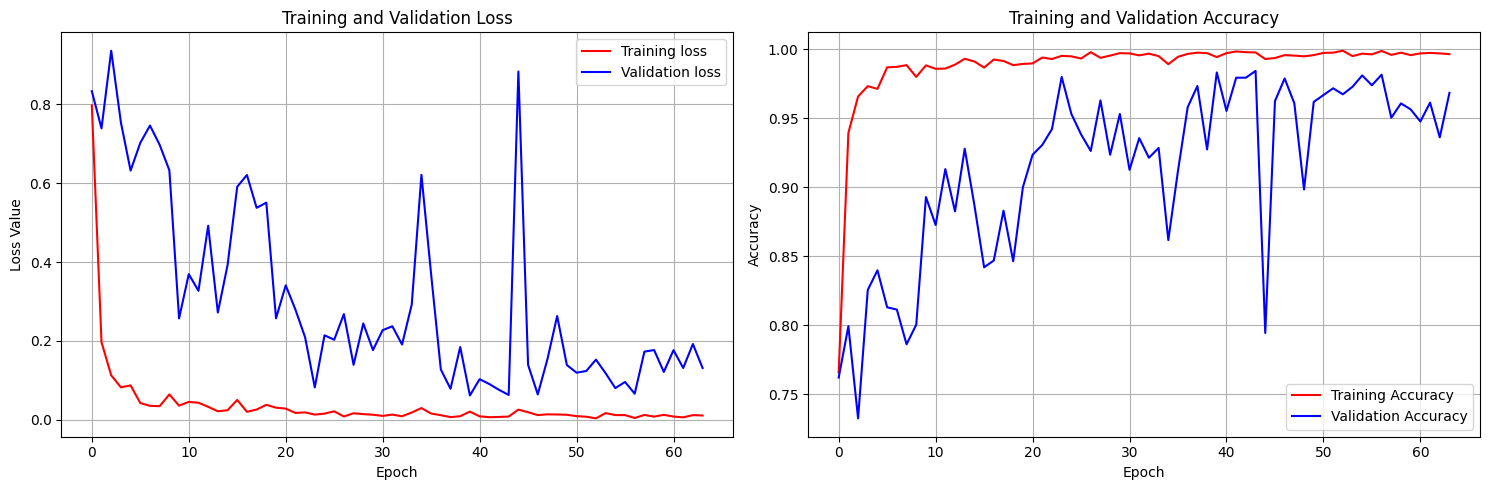

In [32]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

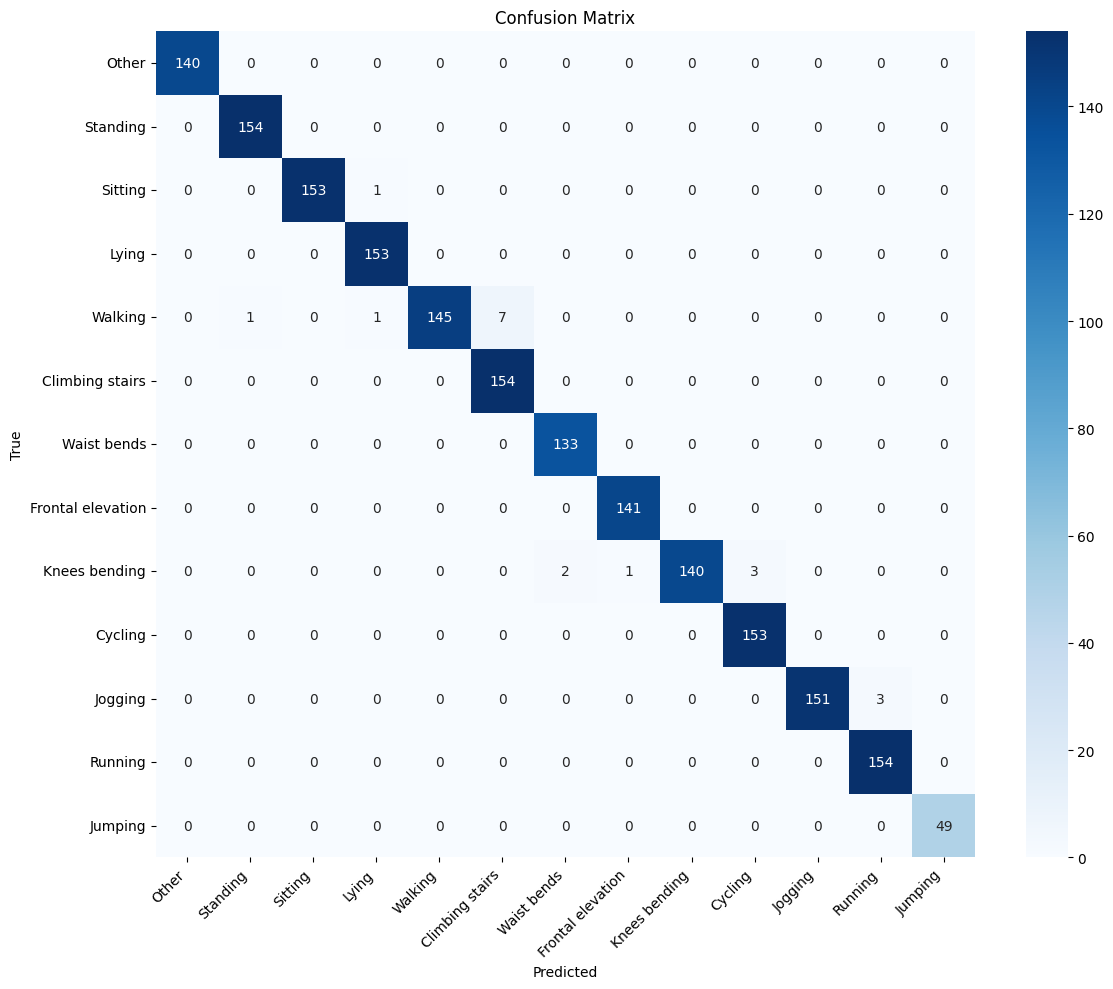

In [34]:
cm = confusion_matrix(y_test_seq, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test_seq))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()